In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import os
from tqdm import tqdm
%matplotlib inline
import os

In [ ]:
#!!! organize dataset into a useful structure
################################
### RUN ONCE ###
###############################
from os import makedirs
from os import listdir
from shutil import copyfile
from random import seed
from random import random

ArtBank = 'images'
Art_Categories = ['abstract','genre-painting','landscape', 'portrait']
# create directories
# dataset_home = 'art_dataset/'
# subdirs = ['train/', 'test/']
# for subdir in subdirs:
#     # create label subdirectories
#     for labldir in Art_Categories:
#         newdir = dataset_home + subdir + labldir
#         makedirs(newdir, exist_ok=True)
# # seed random number generator
# seed(1)

# # define ratio of pictures to use for validation
# val_ratio = 0.10

# # copy training dataset images into subdirectories
# src_directory = 'images/'

# for category in Art_Categories:
#     path=os.path.join(ArtBank, category)
#     for img in listdir(path):
#         src = path + '/' + img
#         dst_dir = 'train/'
#         if random() < val_ratio:
#             dst_dir = 'test/'
#         dst = dataset_home + dst_dir + category + '/'  + img
#         copyfile(src, dst)

In [3]:

#Stroing the images as matrices with 3 components one for each colour aspect
ArtBank = 'images'

# Art_Categories = ['abstract','animal-painting','cityscape','flower-painting','landscape', 'portrait', 'still-life']
Art_Categories = ['abstract','genre-painting','landscape', 'portrait']

#! image size - important parameter
Image_size=128
training_data=[]

train_start = 0
train_end = train_start + 999

def creating_training_data():
    for category in Art_Categories:
        path=os.path.join(ArtBank, category)
        class_num=Art_Categories.index(category)
        i=0
        ld = sorted(os.listdir(path))
        print(path)
        for img in ld:
            if i<train_start:
                i+=1
                continue
            try:
                img_array=cv2.imread(os.path.join(path,img))
                new_array=cv2.resize(img_array,(Image_size,Image_size))
                
                ### added 14:46
                # flipped_img_array = cv2.flip(img_array, 1)
                # training_data.append([flipped_img_array / 255, class_num])
                ###
                
                training_data.append([new_array/255,class_num])#divided by 255
            except Exception as e:
                pass
            if i==train_end: # data size for category
                break
            # if i%(len(ld) / 10)==0:
                # print(f"{(i/2999) * 100}%",end="\r")
            i+=1

creating_training_data()


images\abstract
images\genre-painting
images\landscape
images\portrait


In [4]:
#split the images from the labels
Xr_images = []
yr_labels = []
for categories, label in training_data:
    Xr_images.append(categories)
    yr_labels.append(label)

In [5]:
#Test train split
X_Images = np.array(Xr_images, dtype = 'float32')
from tensorflow.keras.utils import to_categorical 
y_Labels = to_categorical(yr_labels, num_classes = len(Art_Categories))
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_Images, y_Labels, test_size=0.1, random_state=1)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=(0.1), random_state=1) # 0.111 x 0.9 = 0.1
print("x_train shape",X_train.shape)
print("x_test shape",X_val.shape)
print("y_train shape",Y_train.shape)
print("y_test shape",Y_val.shape)


x_train shape (3240, 128, 128, 3)
x_test shape (360, 128, 128, 3)
y_train shape (3240, 4)
y_test shape (360, 4)


###  Network model structure v1.0

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
#Define neural networks structure

### added 14:48
from keras.regularizers import l2

# Define the L2 regularization parameter
l2_reg = 0.001
###

model = Sequential()
### modified 14:51 - changed filters to 4 from 8
model.add(Conv2D(filters = 4, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (Image_size,Image_size,3)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
### modified 14:51 - changed filters to 8 from 16
model.add(Conv2D(filters = 8, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))
# fully connected
model.add(Flatten())
### modified 14:58
model.add(Dense(256, activation = "relu"kernel_regularizer=l2(l2_reg)))
###
model.add(Dropout(0.5))
model.add(Dense(len(Art_Categories), activation = "softmax"))

In [ ]:
#The choice of gradient descent
### modified 14:52 - changed learning rate to 0.0005 from 0.001
optimizer = Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999)

In [ ]:
#Choosing our loss function
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [6]:
epochs = 30  # optimal choice
batch_size = 32

In [37]:
# save model with best validation accuracy
checkpoint_filepath = 'ckpt/checkpoint5.model.keras'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [11]:
# OPTIONAL - load saved model before training
from tensorflow.keras.models import load_model
model = load_model('Art_classification_four.keras')

c:\Users\micha\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [38]:
# Train the model
history = model.fit(X_train,Y_train,
                    epochs = epochs, validation_data = (X_val,Y_val), steps_per_epoch=X_train.shape[0] // batch_size, callbacks=[model_checkpoint_callback])

Epoch 1/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 32s 103ms/step - accuracy: 0.5681 - loss: 1.2271 - val_accuracy: 0.6231 - val_loss: 0.9263
Epoch 2/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 24s 81ms/step - accuracy: 0.6223 - loss: 0.9099 - val_accuracy: 0.6472 - val_loss: 0.8285
Epoch 3/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 25s 82ms/step - accuracy: 0.6644 - loss: 0.8063 - val_accuracy: 0.6407 - val_loss: 0.8392
Epoch 4/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 28s 91ms/step - accuracy: 0.6631 - loss: 0.7847 - val_accuracy: 0.6574 - val_loss: 0.7986
Epoch 5/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 24s 80ms/step - accuracy: 0.6939 - loss: 0.7322 - val_accuracy: 0.6639 - val_loss: 0.7930
Epoch 6/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 24s 79ms/step - accuracy: 0.7099 - loss: 0.6948 - val_accuracy: 0.6750 - val_loss: 0.7976
Epoch 7/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 24s 78ms/step - accuracy: 0.7242 - loss: 0.6682 - val_accuracy: 0.6759 - val_loss: 0.7795
Epoch 8/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 23s 76ms/step - accuracy: 0.7342 - loss: 0.6440 -

In [54]:
# Save the model
model.save('models/v1/Art_Classification_four5.keras')
# model.save('Art_Classification_four.h5')

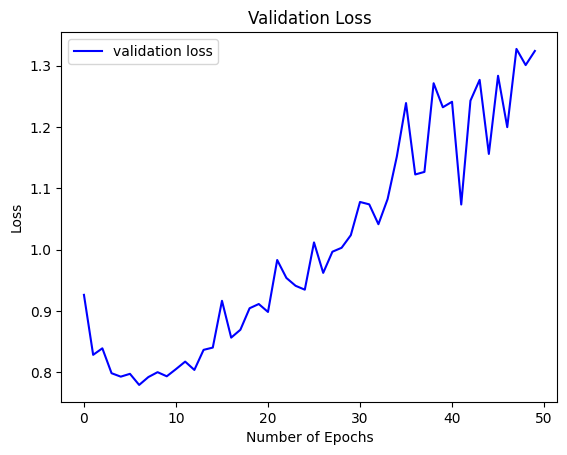

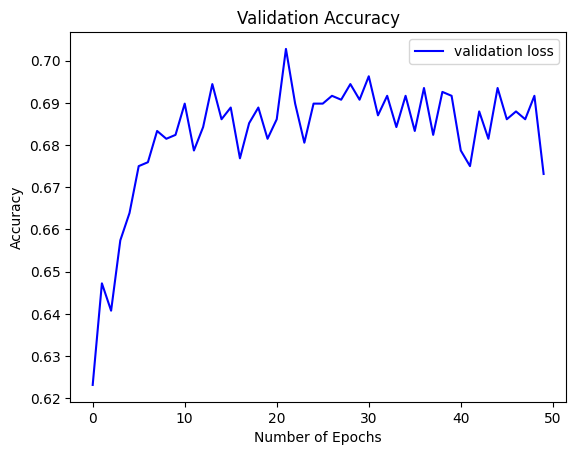

In [39]:
#Plot validation loss
plt.plot(history.history['val_loss'], color='b', label="validation loss")
plt.title("Validation Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
# plot validation accuracy
plt.plot(history.history['val_accuracy'], color='b', label="validation loss")
plt.title("Validation Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [24]:
# os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

# load the saved model (optional)
from tensorflow.keras.models import load_model
model = load_model(filepath="Art_Classification_four.keras")

ValueError: A total of 1 objects could not be loaded. Example error message for object <keras.src.optimizers.adam.Adam object at 0x00000212EDD769F0>:

'Unable to synchronously open object (bad object header version number)'

List of objects that could not be loaded:
[<keras.src.optimizers.adam.Adam object at 0x00000212EDD769F0>]

In [40]:
# Predict the values from the test dataset
Y_pred = model.predict(X_test)
 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 

Y_true = np.argmax(Y_test,axis = 1) 

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [7]:
from tensorflow.keras.models import load_model
best_model_numbers = [10, 11, 16, 17, 18]

for num in best_model_numbers:
    model_name = f"ckpt/v2/checkpoint{num}.model.keras"
    model = load_model(model_name)
    
    Y_pred = model.predict(X_test)
 
    Y_pred_classes = np.argmax(Y_pred,axis = 1) 

    Y_true = np.argmax(Y_test,axis = 1)
    
    from sklearn.metrics import accuracy_score
    print(f"Test accuracy with model v2.ckpt.{num} is ",accuracy_score(Y_true,Y_pred_classes))


ValueError: A total of 1 objects could not be loaded. Example error message for object <keras.src.optimizers.adam.Adam object at 0x0000021284F5E630>:

'Unable to synchronously open object (bad object header version number)'

List of objects that could not be loaded:
[<keras.src.optimizers.adam.Adam object at 0x0000021284F5E630>]

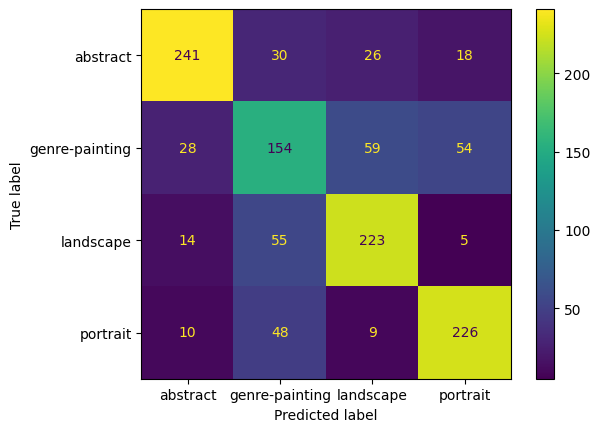

In [47]:
#Confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# import seaborn as sns

confusion_matrix_1 = confusion_matrix(Y_true, Y_pred_classes) 

# f,ax = plt.subplots(figsize=(8, 8))
# sns.heatmap(confusion_matrix_1, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.title("Confusion Matrix")
# plt.show()

confusion_matrix_2 = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_1, display_labels=Art_Categories)
confusion_matrix_2.plot()

In [42]:
# Accuracy
from sklearn.metrics import accuracy_score
print("Accuracy on training data is",accuracy_score(Y_true,Y_pred_classes))


Accuracy on training data is 0.7033333333333334


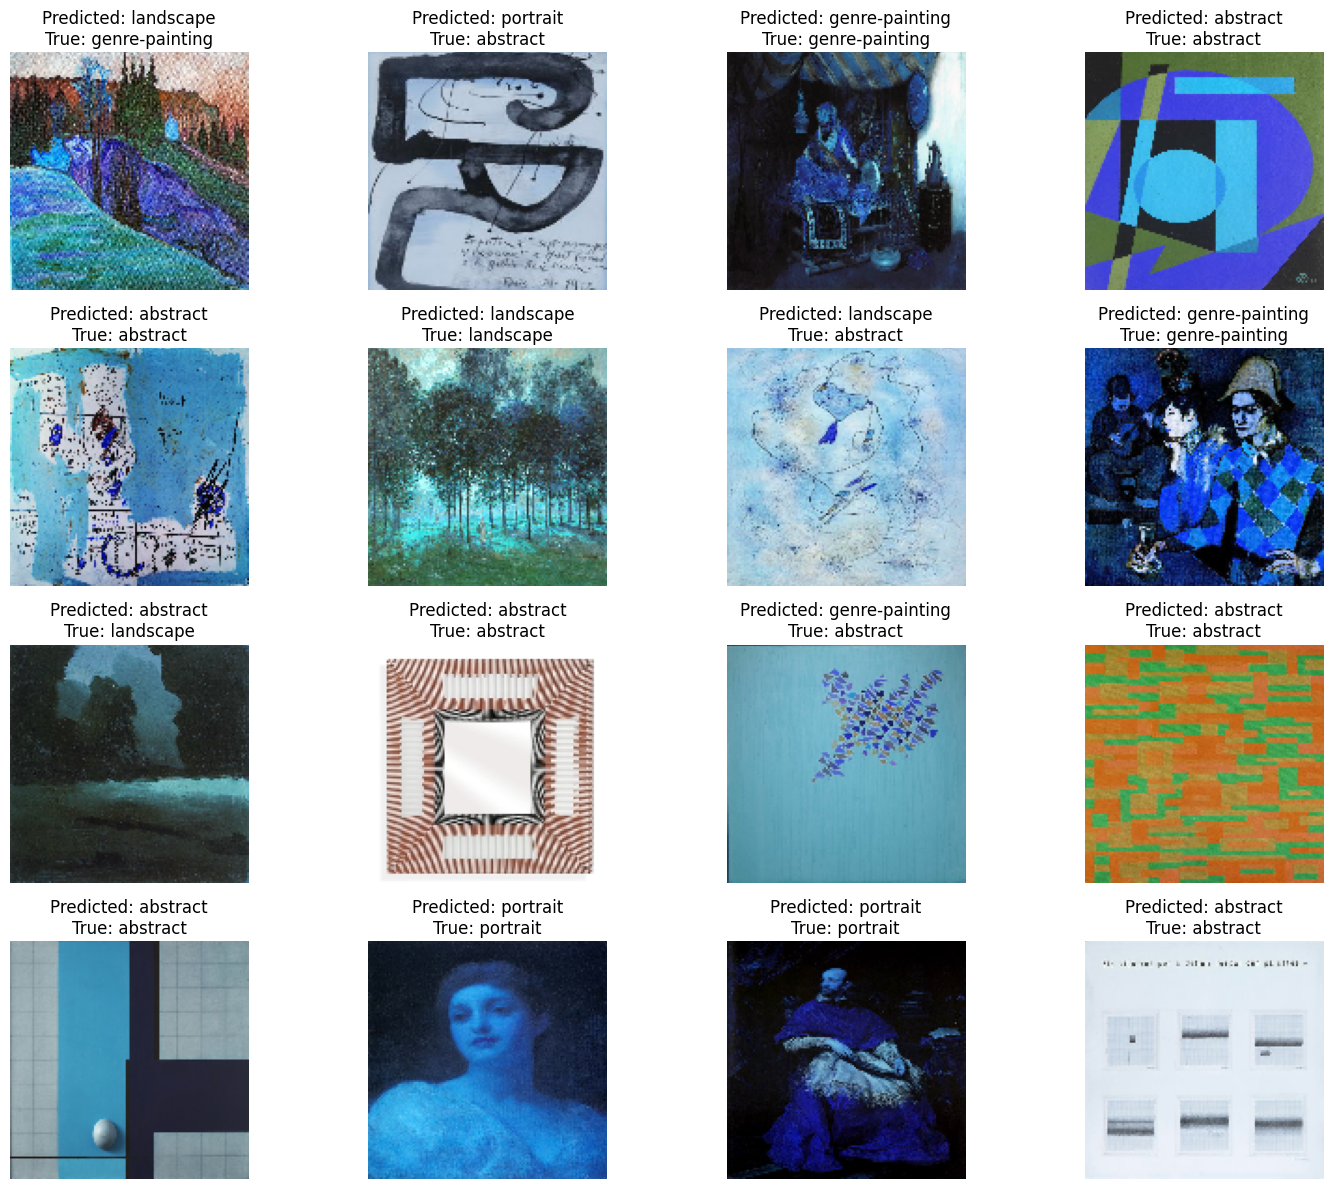

In [53]:
# display some images and their predicted and true labels
import matplotlib.pyplot as plt

# Select a few indices of test images to plot (modify as needed)
import random

# Generate 10 random numbers between 0 (inclusive) and 1 (exclusive)
image_indices = [random.randint(0, len(Y_pred_classes)) for _ in range(16)]

# Get the predicted and true class labels for these images
predicted_classes = Y_pred_classes[image_indices]
true_classes = Y_true[image_indices]

# Get class names from Art_Categories (assuming it's defined elsewhere)
class_names = Art_Categories

# Calculate the number of columns and rows for a 3xN grid
num_images = len(image_indices)
num_cols = 4
# num_rows = (num_images // num_cols) + (num_images % num_cols > 0)  # Add a row if not perfectly divisible
num_rows = 4

# Create a figure for plotting
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 12))  # Adjust figsize for better visualization

# Flatten the axes for easier iteration
axes_flat = axes.flatten()

# Loop through the selected indices and plot images with labels
for i, (index, predicted_class, true_class) in enumerate(zip(image_indices, predicted_classes, true_classes)):
  image = X_test[index]  # Assuming your test images are stored in X_test

  # Rescale the image back to 0-255 range if necessary (depending on preprocessing)
  image = image * 255

  axes_flat[i].imshow(image.astype(int))
  axes_flat[i].set_title(f"Predicted: {class_names[predicted_class]}\nTrue: {class_names[true_class]}")
  axes_flat[i].axis('off')  # Hide axes for cleaner visualization

# Tight layout to prevent overlapping labels
plt.tight_layout()

# Display the plotted images
plt.show()
